In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

standardScaler = joblib.load('../pipeline/StandardScalerPipeline.pkl')

In [2]:
X = pd.read_csv('../dataset/X.csv')
y = pd.read_csv('../dataset/y.csv')

In [3]:
X.head()

,Size,Bedrooms,Bathrooms,Lat,Long,Amenities_Score,BedtoBath_Ratio,Furnished,Apartment,Duplex,Penthouse,Room,Studio,TotalRooms,Level_category,accessibility_score
0,165,3,3,30.093319,31.637916,8,1.000000,1,1,0,0,0,0,6,0,0
1,225,3,3,30.023628,31.304425,5,1.000000,1,1,0,0,0,0,6,0,0
2,280,4,3,30.052118,31.342205,7,0.750000,0,1,0,0,0,0,7,0,0
3,120,3,2,30.052118,31.342205,6,0.666667,1,1,0,0,0,0,5,0,0
4,197,3,3,30.051086,31.537079,8,1.000000,0,1,0,0,0,0,6,0,0


In [4]:
y = np.array(y).ravel()
y[:5]

array([35000, 77000, 30000,  1500, 22000], dtype=int64)

In [5]:
stdX = standardScaler.transform(X)

d:\installled_programs\miniconda\envs\cairohouse\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
d:\installled_programs\miniconda\envs\cairohouse\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\installled_programs\miniconda\envs\cairohouse\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\installled_programs\miniconda\envs\cairohouse\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated

In [6]:
X_train, X_test, y_train, y_test = train_test_split(stdX, y, test_size=0.1, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9548, 16)
(9548,)
(1061, 16)
(1061,)


In [7]:
def print_metrics(y_true, preds):
    mae = mean_absolute_error(y_true, preds)
    mse = mean_squared_error(y_true, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, preds)
    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'R2:{r2:.4f}\n')

def cv_evaluate(model):
    # Check CV Scores
    scores = cross_val_score(model, X_train, y_train, cv=5)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    print('Cross Validation Scores:')
    print(f'CV_scores = {scores}')
    print('CV mean:', "{:.4f}".format(np.mean(scores)))
    print('CV Std:', "{:.4f}".format(np.std(scores)), '\n')

    # print Accuracy Scores
    print("Train Scores:")
    print_metrics(y_train, train_preds)
    print("Test Scores:")
    print_metrics(y_test, test_preds)

In [8]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_leaf=5,
    min_samples_split=15,
    max_features='sqrt',
    bootstrap=True,
)
rf_model.fit(X_train, y_train)
cv_evaluate(rf_model)

Cross Validation Scores:
CV_scores = [0.60588734 0.6073016  0.64111168 0.61337914 0.60598136]
CV mean: 0.6147
CV Std: 0.0135 

Train Scores:
MAE: 5250.78
RMSE: 8028.52
R2:0.6945

Test Scores:
MAE: 5845.04
RMSE: 8736.75
R2:0.6149



In [9]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [5, 10, 15],
    'max_features': ['sqrt', 'log2']
}

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
print(f'Best parameters found: {grid_search.best_params_}')

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}


In [10]:
best_rf_model = grid_search.best_estimator_
cv_evaluate(best_rf_model)

Cross Validation Scores:
CV_scores = [0.60833673 0.60598614 0.64772391 0.61473637 0.60592581]
CV mean: 0.6165
CV Std: 0.0159 

Train Scores:
MAE: 5144.31
RMSE: 7886.42
R2:0.7052

Test Scores:
MAE: 5788.03
RMSE: 8663.68
R2:0.6213



## Train on all dataset

In [11]:
best_rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=5,
    min_samples_split=5,
    max_features='sqrt',
    bootstrap=True,
)
best_rf_model.fit(stdX, y)
print_metrics(y, best_rf_model.predict(stdX))

MAE: 5154.45
RMSE: 7882.30
R2:0.7037



<Axes: title={'center': 'Feature Importance'}>

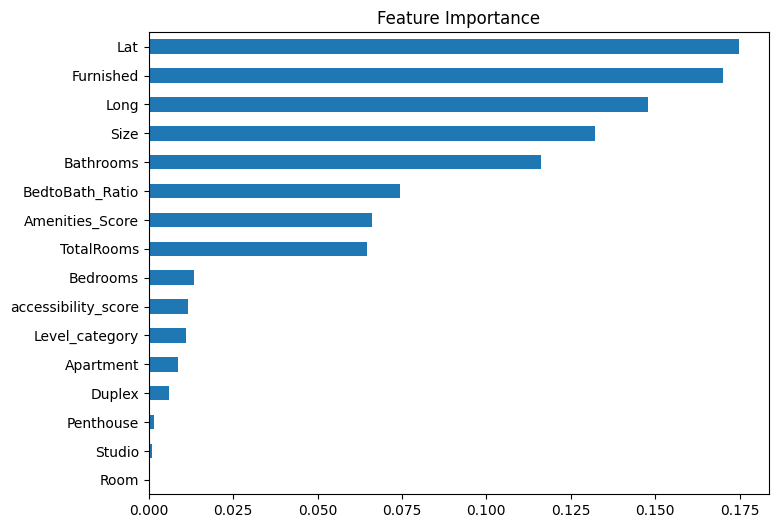

In [28]:
pd.DataFrame(best_rf_model.feature_importances_, index=X.columns, columns=['importance']) \
    .sort_values('importance', ascending=True) \
    .plot(kind='barh', figsize=(8, 6), title='Feature Importance', legend=False)

## Save the model to file

In [12]:
joblib.dump(best_rf_model, '../pipeline/rf_model.pkl')

['../pipeline/rf_model.pkl']